In [1]:
import geopandas as gpd
import shapely.geometry as Point
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import folium
from folium.plugins import HeatMap

In [3]:
# Get all postcodes for local area
LOCAL_LAT = 51.5146
LOCAL_LNG = -2.5820
RADIUS_METRES = 2000 # 2km within the central point for local city

def fetch_local_postcodes(lat, lng, radius=2000):
    postcode_url = f"https://api.postcodes.io/postcodes?lon={LOCAL_LNG}&lat={LOCAL_LAT}&radius={RADIUS_METRES}"
    print("Fetching nearby postcodes...")

    try:
        response = requests.get(postcode_url)
        data = response.json()
    except Exception as err:
        print(f"Couldn't fetch data. {err}")

    return data

data = fetch_local_postcodes(LOCAL_LAT, LOCAL_LNG, RADIUS_METRES)
postcodes = [p['postcode'] for p in data['result']]
print(postcodes)
print(f"Found {len(postcodes)} nearby postcodes..")


Fetching nearby postcodes...
['BS34 7QS', 'BS34 7BA', 'BS34 7QQ', 'BS34 7QB', 'BS34 4AQ', 'BS34 4AJ', 'BS34 4AL', 'BS34 7PA', 'BS34 7AD', 'BS34 7PZ']
Found 10 nearby postcodes..


In [4]:
def fetch_nearby_crime_data(postcodes:list):
    all_crimes = []

    for postcode in postcodes:

        # Get latitude and longitude for the postcode
        postcode_lat_lng = requests.get(f"https://api.postcodes.io/postcodes/{postcode}").json()
        result = postcode_lat_lng.get('result')

        if not result:
            print(f"Couldn't find latitude and longitude for {postcode}, skipping...")


        lat = result['latitude']
        lng = result['longitude']

        # Get police crime data from police API
        police_api_url = f"https://data.police.uk/api/crimes-street/all-crime?lat={lat}&lng={lng}"
        # print(f"\nFetching crimes near {postcode}...")

        crime_response = requests.get(police_api_url)
        crimes = crime_response.json()

        for crime in crimes:
            crime['postcode'] = postcode
        
        all_crimes.extend(crimes)

        # print(f"Found {len(crimes)} crimes near {postcode}.")

        # test -
        # for crime in crimes[:3]:
        #     print(f"  - {crime['category']} at {crime['location']['street']['name']}")

        
        time.sleep(1) # wait for 1 second

    print("\nFetching crime data completed.")
    
    return all_crimes   

crime_data = fetch_nearby_crime_data(postcodes)

print(crime_data)



Fetching crime data completed.
[{'category': 'anti-social-behaviour', 'location_type': 'Force', 'location': {'latitude': '51.504003', 'street': {'id': 2279693, 'name': 'On or near The Wicketts'}, 'longitude': '-2.578959'}, 'context': '', 'outcome_status': None, 'persistent_id': '', 'id': 126954826, 'location_subtype': '', 'month': '2025-03', 'postcode': 'BS34 7QS'}, {'category': 'anti-social-behaviour', 'location_type': 'Force', 'location': {'latitude': '51.513031', 'street': {'id': 2280235, 'name': 'On or near Rodney Crescent'}, 'longitude': '-2.571378'}, 'context': '', 'outcome_status': None, 'persistent_id': '', 'id': 126954994, 'location_subtype': '', 'month': '2025-03', 'postcode': 'BS34 7QS'}, {'category': 'anti-social-behaviour', 'location_type': 'Force', 'location': {'latitude': '51.513031', 'street': {'id': 2280235, 'name': 'On or near Rodney Crescent'}, 'longitude': '-2.571378'}, 'context': '', 'outcome_status': None, 'persistent_id': '', 'id': 126955680, 'location_subtype':

In [5]:
# Convert to DataFrame
df = pd.DataFrame(crime_data)
df.head()

,category,location_type,location,context,outcome_status,persistent_id,id,location_subtype,month,postcode
0,anti-social-behaviour,Force,"{'latitude': '51.504003', 'street': {'id': 227...",,None,,126954826,,2025-03,BS34 7QS
1,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",,None,,126954994,,2025-03,BS34 7QS
2,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",,None,,126955680,,2025-03,BS34 7QS
3,anti-social-behaviour,Force,"{'latitude': '51.509414', 'street': {'id': 228...",,None,,126955191,,2025-03,BS34 7QS
4,anti-social-behaviour,Force,"{'latitude': '51.500977', 'street': {'id': 227...",,None,,126955944,,2025-03,BS34 7QS


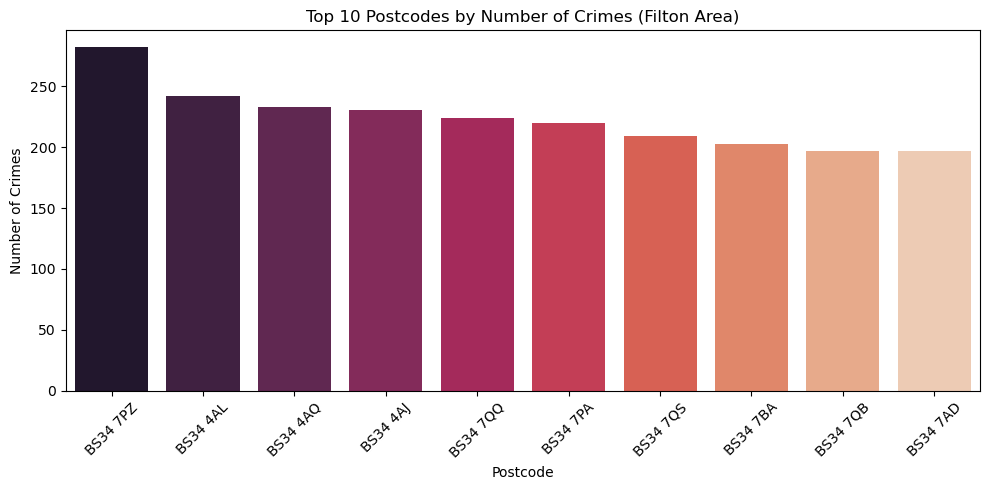

In [6]:
# Top 10 postcodes with most crime
top_postcodes = df['postcode'].value_counts().nlargest(100)
plt.figure(figsize=(10, 5))
sns.barplot(x=top_postcodes.index, y=top_postcodes.values, palette="rocket")
plt.title('Top 10 Postcodes by Number of Crimes (Filton Area)')
plt.xlabel('Postcode')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

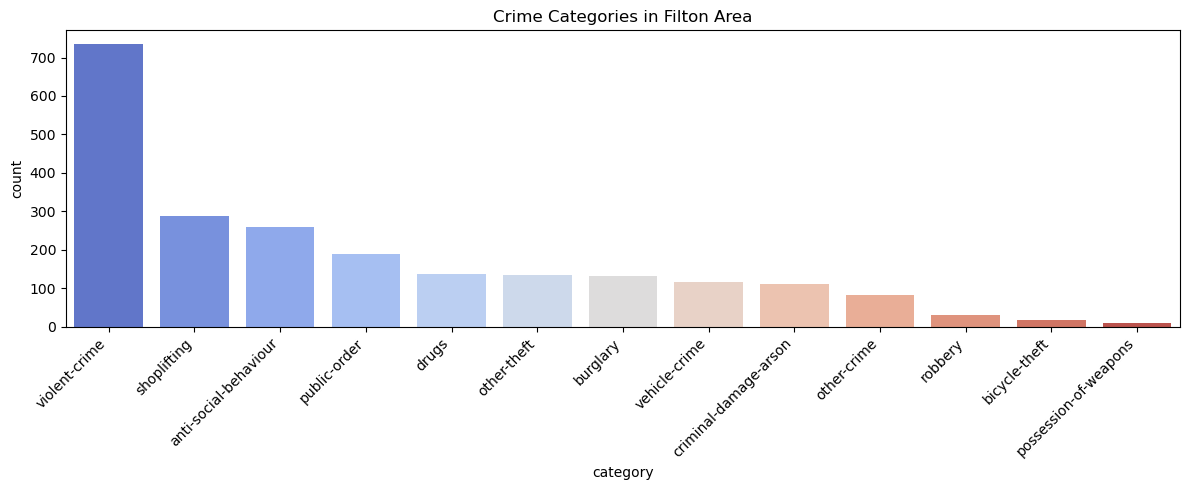

In [7]:
# Crime category vs Number of Crimes
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index, palette="coolwarm")
plt.title('Crime Categories in Filton Area')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [8]:
# Create map centred on Filton
crime_map = folium.Map(location=[LOCAL_LAT, LOCAL_LNG], zoom_start=14)

# Filter out missing data
df = df[df['location'].notnull() & df['location'].apply(lambda loc: loc.get('latitude') and loc.get('longitude'))]

df['lat'] = df['location'].apply(lambda loc: float(loc['latitude']))
df['lng'] = df['location'].apply(lambda loc: float(loc['longitude']))

heat_data = df[['lat', 'lng']].values.tolist()

# Add heat effect to the map
HeatMap(heat_data, radius=15, blur=25, max_zoom=15).add_to(crime_map)

# Save map as HTML
crime_map.save("../assets/filton_crime_map.html")
print("Crime heatmap saved as filton_crime_map.html. Open it in a browser!")

Crime heatmap saved as filton_crime_map.html. Open it in a browser!


In [9]:
# Get all column names
df.columns

Index(['category', 'location_type', 'location', 'context', 'outcome_status',
       'persistent_id', 'id', 'location_subtype', 'month', 'postcode', 'lat',
       'lng'],
      dtype='object')

In [10]:
# Shape
df.shape

(2238, 12)

In [11]:
# Replace empty strings with NaN for uniformity
df_cleaned = df.replace('', np.nan)

# Total number of rows with missing values
df_cleaned.isna().sum()

category               0
location_type          0
location               0
context             2238
outcome_status       259
persistent_id        259
id                     0
location_subtype    2238
month                  0
postcode               0
lat                    0
lng                    0
dtype: int64

In [12]:
# Drop irrelevant columns
df_cleaned = df_cleaned.drop(columns=['outcome_status', 'context', 'persistent_id', 'location_subtype'], axis=1)
df_cleaned.head()

,category,location_type,location,id,month,postcode,lat,lng
0,anti-social-behaviour,Force,"{'latitude': '51.504003', 'street': {'id': 227...",126954826,2025-03,BS34 7QS,51.504003,-2.578959
1,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",126954994,2025-03,BS34 7QS,51.513031,-2.571378
2,anti-social-behaviour,Force,"{'latitude': '51.513031', 'street': {'id': 228...",126955680,2025-03,BS34 7QS,51.513031,-2.571378
3,anti-social-behaviour,Force,"{'latitude': '51.509414', 'street': {'id': 228...",126955191,2025-03,BS34 7QS,51.509414,-2.571967
4,anti-social-behaviour,Force,"{'latitude': '51.500977', 'street': {'id': 227...",126955944,2025-03,BS34 7QS,51.500977,-2.574368


In [13]:
# Regex pattern for YYYY-MM format
pattern = r'^\d{4}-(0[1-9]|1[0-2])$'

# Cound the number of invalid dates
valid_count = (~df_cleaned['month'].str.match(pattern)).sum()
print(f"Number of invalid dates: {valid_count}")

Number of invalid dates: 0


In [14]:
# Seperate Year and Month to different columns
# df_cleaned[["year", "month"]] = df["month"].str.split("-", expand = True)
# df_cleaned.head()

In [15]:
# Count crime categories
crime_category_count = df_cleaned['category'].value_counts()
print(crime_category_count)

violent-crime            734
shoplifting              289
anti-social-behaviour    259
public-order             188
drugs                    137
other-theft              134
burglary                 131
vehicle-crime            115
criminal-damage-arson    112
other-crime               82
robbery                   30
bicycle-theft             17
possession-of-weapons     10
Name: category, dtype: int64


In [16]:
# Recategorised crimes to imporve generalisation
crime_category_map = {
    'violent-crime': 'violence',
    'robbery': 'violence',
    'shoplifting': 'theft',
    'burglary': 'theft',
    'vehicle-crime': 'theft',
    'bicycle-theft': 'theft',
    'other-theft': 'theft',
    'anti-social-behaviour': 'anti-social',
    'public-order': 'anti-social',
    'criminal-damage-arson': 'anti-social',
    'drugs': 'drugs',
    'possession-of-weapons': 'other', 
    'other-crime': 'other'
}

df_cleaned['recategorised_crimes'] = df_cleaned['category'].map(crime_category_map)

# Assign any unmapped crimes to 'other' category
df_cleaned['recategorised_crimes'] = df_cleaned['recategorised_crimes'].fillna('other')

crime_category_count = df_cleaned['recategorised_crimes'].value_counts()
print(crime_category_count)

violence       764
theft          686
anti-social    559
drugs          137
other           92
Name: recategorised_crimes, dtype: int64


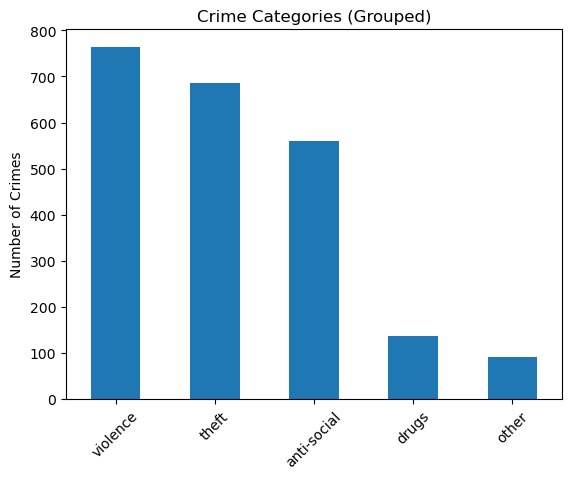

In [17]:
df_cleaned['recategorised_crimes'].value_counts().plot(kind='bar')
plt.title("Crime Categories (Grouped)")
plt.ylabel("Number of Crimes")
plt.xticks(rotation=45)
plt.show()

In [18]:
# Total crimes per postcode
total_crimes_per_postcode = df_cleaned.groupby('postcode').size().reset_index(name='total_crimes')
print(total_crimes_per_postcode)

   postcode  total_crimes
0  BS34 4AJ           231
1  BS34 4AL           242
2  BS34 4AQ           233
3  BS34 7AD           197
4  BS34 7BA           203
5  BS34 7PA           220
6  BS34 7PZ           282
7  BS34 7QB           197
8  BS34 7QQ           224
9  BS34 7QS           209


In [19]:
# Top crime category per postcode
top_category_per_postcode = (
    df_cleaned.groupby(['postcode', 'recategorised_crimes']).size().reset_index(name='count').sort_values(['postcode', 'count'], ascending=[True, False]).drop_duplicates('postcode').rename(columns={'recategorised_crimes': 'top_crime_category'}).drop('count', axis=1)
)
print(top_category_per_postcode)

    postcode top_crime_category
3   BS34 4AJ              theft
8   BS34 4AL              theft
13  BS34 4AQ              theft
18  BS34 7AD              theft
24  BS34 7BA           violence
29  BS34 7PA           violence
34  BS34 7PZ           violence
39  BS34 7QB           violence
44  BS34 7QQ           violence
49  BS34 7QS           violence


In [20]:
# Crimes per postcode per month
monthly_crime = (
    df_cleaned.groupby(['postcode', 'month'])
    .size()
    .reset_index(name='monthly_crimes')
)
print(monthly_crime)

   postcode    month  monthly_crimes
0  BS34 4AJ  2025-03             231
1  BS34 4AL  2025-03             242
2  BS34 4AQ  2025-03             233
3  BS34 7AD  2025-03             197
4  BS34 7BA  2025-03             203
5  BS34 7PA  2025-03             220
6  BS34 7PZ  2025-03             282
7  BS34 7QB  2025-03             197
8  BS34 7QQ  2025-03             224
9  BS34 7QS  2025-03             209


In [21]:
# Merge summaries into one master table
postcode_summary = total_crimes_per_postcode.merge(top_category_per_postcode, on='postcode')
print(postcode_summary)

   postcode  total_crimes top_crime_category
0  BS34 4AJ           231              theft
1  BS34 4AL           242              theft
2  BS34 4AQ           233              theft
3  BS34 7AD           197              theft
4  BS34 7BA           203           violence
5  BS34 7PA           220           violence
6  BS34 7PZ           282           violence
7  BS34 7QB           197           violence
8  BS34 7QQ           224           violence
9  BS34 7QS           209           violence


In [23]:
# Check time range
print(df_cleaned['month'].min(), df_cleaned['month'].max())

2025-03 2025-03
